In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Get the position of the Sun

il y a une librairie : PySolar !

http://pysolar.org/  
http://docs.pysolar.org/en/latest/

     pip install pysolar


Rq: voir aussi une app js en ligne: http://suncalc.net/ 

In [2]:
map_coords = (45.1973288, 5.7103223) #( 45.166672, 5.71667 ) 

In [3]:
import pysolar.solar as solar
import datetime as dt

In [4]:
d = dt.datetime.now()
d = dt.datetime(2017, 6, 20, 13, 30, 0, 130320)

In [5]:
solar.get_altitude( *map_coords, d)

/home/etienne/Projets/thermique_appart/py3/lib/python3.5/site-packages/pysolar/time.py:105: UserWarning: I don't know about leap seconds after 2015
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


68.16881437084149

In [6]:
solar.get_azimuth(*map_coords, d)

/home/etienne/Projets/thermique_appart/py3/lib/python3.5/site-packages/pysolar/time.py:105: UserWarning: I don't know about leap seconds after 2015
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


-354.60975005786054

In [7]:
Alt = [ solar.get_altitude(*map_coords, dt.datetime(2017, 12, 21, h, 0, 0, 0)) for h in range(0, 24) ]
Az = [ solar.get_azimuth(*map_coords, dt.datetime(2017, 12, 21, h, 0, 0, 0)) for h in range(0, 24) ]

/home/etienne/Projets/thermique_appart/py3/lib/python3.5/site-packages/pysolar/time.py:105: UserWarning: I don't know about leap seconds after 2015
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


In [8]:
Az = np.array( Az )

Az[ Az < -180 ] = Az[ Az < -180 ]+360

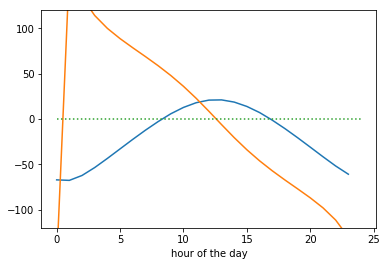

In [9]:
plt.plot( Alt )
plt.plot( Az )
plt.plot([0, 24], [0, 0], ':'); plt.ylim([-120, 120]); plt.xlabel('hour of the day');

In [10]:
import pysolar.radiation as radiation

In [11]:
radiation.get_radiation_direct( d, 65 )   # W/m2

864.9821032273021

**Remarque:** Le flux solaire au dessus de l'atmosphère est de F = 1 360,8  W/m2
    
https://fr.wikipedia.org/wiki/Constante_solaire

### Avec l'horizon

In [12]:
from numpy import genfromtxt

In [13]:
horizon_data = genfromtxt('horizon.csv', delimiter=',').T

In [14]:
horizon_data

array([[-180.    , -179.5   , -179.    , ...,  179.    ,  179.5   ,  180.    ],
       [   6.6451,   14.0111,   14.4924, ...,   12.8084,   13.0535,
          13.5404]])

In [53]:
def isUpperHorizon( azimuth, altitude_deg ):
    h = np.interp(-azimuth, horizon_data[0, :], horizon_data[1, :])

    if h > altitude_deg:
        return 0
    else:
        return 1

In [54]:
isUpperHorizon( 20, 2 )

1

In [55]:
horizon_data[1, :].max()

15.9122

## Projection sur une surface inclinée 
http://www.a-ghadimi.com/files/Courses/Renewable%20Energy/REN_Book.pdf

page 414

In [56]:
import math
import pysolar.radiation as radiation
import pysolar.solar as solar
import datetime as dt

In [57]:
def get_radiation_direct(d, alt):
    if alt>0:
        return radiation.get_radiation_direct( d, alt )   # W/m2
    else:
        return 0
    
def get_flux_surface( coords, date, sigma, phi_C ):
    # Surface orientation 
    # sigma : deg, vertical angle of the surface, ref. to the horizontal
    # phi_C : deg, azimuth, relative to south, with positive values in the southeast direction and negative values in
    # the southwest
    
    # Sun position
    phi_S_deg = solar.get_azimuth( *coords, date ) # deg, azimuth of the sun,relative to south
    beta_deg = solar.get_altitude( *coords, date ) # deg, altitude angle of the sun
    
    I0 = get_radiation_direct( d, beta_deg )   # W/m2
    I0 = I0* isUpperHorizon( phi_S_deg, beta_deg )
    
    beta = beta_deg*math.pi/180  # rad
    phi_S = phi_S_deg*math.pi/180  #rad
    sigma = sigma*math.pi/180
    phi_C = phi_C*math.pi/180
    
    cosTheta = math.cos(beta)*math.cos( phi_S - phi_C )*math.sin( sigma ) + math.cos( sigma )*math.sin( beta )
    
    if cosTheta >0 :
        Isurf = I0*cosTheta   # flux projeté, W/m2
    else:
        Isurf = 0  # mais diffuse... 
        
    return Isurf

def get_flux_total( coords, date ):
    # Sun position
    beta_deg = solar.get_altitude( *coords, date ) # deg, altitude angle of the sun
    
    I0 = get_radiation_direct( d, beta_deg )   # W/m2
        
    return I0

In [58]:
get_radiation_direct( d, -4 )

0

In [59]:
d = dt.datetime(2017, 6, 22, 11, 0, 0, 0)
sigma = 37
phi_C = 50

F = get_flux_surface( map_coords, d, sigma, phi_C )
print( F )


814.1677834421273


/home/etienne/Projets/thermique_appart/py3/lib/python3.5/site-packages/pysolar/time.py:105: UserWarning: I don't know about leap seconds after 2015
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


In [60]:
import pandas as pd

In [61]:
start =  dt.datetime(2017, 6, 22, 0, 0, 0, 0)
end =  dt.datetime(2017, 6, 22, 23, 59, 0, 0)

d_range = pd.date_range( start=start, end=end, freq='5min' )

In [62]:
F_tot = [ get_flux_total(map_coords, d ) for d in d_range ]
F_est = [ get_flux_surface(map_coords, d, sigma, phi_C ) for  d in d_range ]
F_ouest = [ get_flux_surface(map_coords, d, sigma, phi_C+180 ) for d in d_range ]
F_sud = [ get_flux_surface(map_coords, d, 90, phi_C-90 ) for d in d_range ]

/home/etienne/Projets/thermique_appart/py3/lib/python3.5/site-packages/pysolar/time.py:105: UserWarning: I don't know about leap seconds after 2015
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


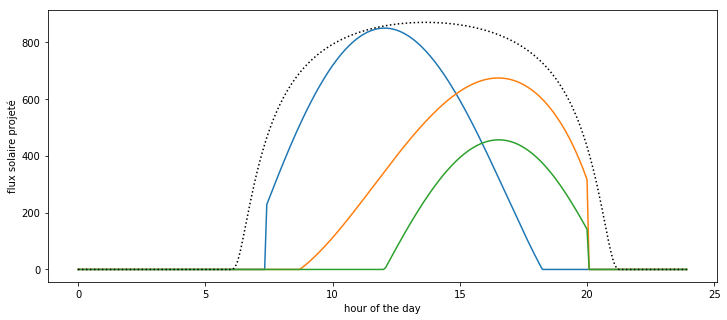

In [63]:
x = d_range.hour + d_range.minute/60

plt.figure(figsize=(12, 5))
plt.plot( x, F_est )
plt.plot( x, F_ouest )
plt.plot( x, F_sud )
plt.plot( x, F_tot, 'k:' )
plt.xlabel('hour of the day');
plt.ylabel('flux solaire projeté');

In [64]:
d_range.hour + d_range.minute/60

Float64Index([            0.0, 0.0833333333333,  0.166666666667,
                         0.25,  0.333333333333,  0.416666666667,
                          0.5,  0.583333333333,  0.666666666667,
                         0.75,
              ...
                23.1666666667,           23.25,   23.3333333333,
                23.4166666667,            23.5,   23.5833333333,
                23.6666666667,           23.75,   23.8333333333,
                23.9166666667],
             dtype='float64', length=288)

In [ ]:
# Sun position
phi_S = solar.get_azimuth( *map_coords, d ) # deg, azimuth of the sun,relative to south
beta = solar.get_altitude( *map_coords, d ) # deg, altitude angle of the sun

I0 = radiation.get_radiation_direct( d, 65 )   # W/m2

cosTheta = math.cos(beta)*math.cos( phi_S - phi_C )*math.sin( sigma ) + math.cos( sigma )*math.sin( beta )

Isurf = I0*cosTheta   # flux projeté, W/m2

In [ ]:
cosTheta

## Verif

In [51]:
Azi = np.array( [ solar.get_azimuth( *map_coords, d ) for d in d_range ] )

Azi[ Azi < -180 ] = Azi[ Azi < -180 ]+360

Alt = [ solar.get_altitude( *map_coords, d ) for d in d_range ]
Hor = [ np.interp(-a, horizon_data[0, :], horizon_data[1, :]) for a in Azi ]

/home/etienne/Projets/thermique_appart/py3/lib/python3.5/site-packages/pysolar/time.py:105: UserWarning: I don't know about leap seconds after 2015
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


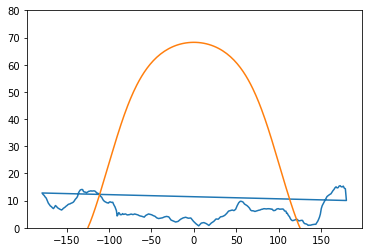

In [65]:
plt.plot( Azi, Hor )
plt.plot( Azi, Alt )
plt.ylim([0, 80]);

In [40]:
Azi

[-156.20139906919525,
 -157.35005412193766,
 -158.50626305301813,
 -159.66977583554535,
 -160.84032129275806,
 -162.01760706071286,
 -163.2013202892822,
 -164.3911284786617,
 -165.58667980207406,
 -166.78760337810354,
 -167.99351127919272,
 -169.20399824350483,
 -170.41864393032074,
 -171.63701366551788,
 -172.85865945476417,
 -174.0831217431234,
 -175.3099312738409,
 -176.53861036636567,
 -177.7686740900823,
 -178.99963314665303,
 -180.23099431445462,
 -181.4622634019026,
 -182.6929465526473,
 -183.92255172060993,
 -185.1505907835824,
 -186.376581627983,
 -187.6000495253354,
 -188.8205282872421,
 -190.03756299230065,
 -191.25071016842116,
 -192.45954034286058,
 -193.66363884596774,
 -194.8626066822876,
 -196.05606193441406,
 -197.2436410398381,
 -198.42499930366728,
 -199.5998111378948,
 -200.76777176092457,
 -201.92859640330153,
 -203.08202176074508,
 -204.22780574979214,
 -205.3657273300792,
 -206.49558683395963,
 -207.61720618938784,
 -208.73042844029828,
 -209.8351170463444,
 -210